In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import gc
import cv2

Digit recognizer training data

In [82]:
df_train_data = pd.read_csv("C:/Users/lamto/Desktop/digit/data/train.csv")
df_test_data = pd.read_csv("C:/Users/lamto/Desktop/digit/data/test.csv")
df_train_data.head(10)

MemoryError: Unable to allocate 252. MiB for an array with shape (785, 42000) and data type int64

Cột đầu tiên chứa 'nhãn', và cho biết chữ số nào được thể hiện bởi hình ảnh trong hàng đó. Chúng ta có thể tách nhãn ra khỏi dữ liệu điểm ảnh trong dữ liệu huấn luyện, bằng cách đơn giản là chuyển cột đầu tiên vào một DataFrame riêng

In [ ]:
X = df_train_data.drop(columns=['label'])  # Dữ liệu đầu vào
Y = df_train_data['label']                 # Nhãn tương ứng

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

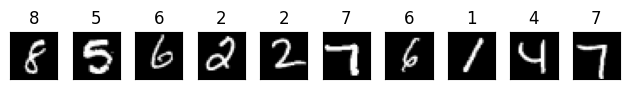

In [ ]:
# Dữ liệu từ 0 - 9 bắt đầu từ cột đầu tiên
# Sau đó là 0-783 dữ liệu điểm ảnh
# Mỗi hình ảnh có kích thước 28 x 28 pixel, do đó tạo thành một lưới gồm 784 điểm ảnh.
# Tách dữ liệu điểm ảnh ra khỏi nhãn trong dữ liệu huấn luyện:

# Hiển thị 10 ảnh đầu tiên trong tập huấn luyện
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    ax.imshow(X_train.iloc[i].values.reshape(28, 28), cmap='gray')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(y_train.iloc[i])

plt.tight_layout()
plt.show()

Có 2 yếu tố ảnh hưởng đến độ chính xác của mô hình KNN:
K: Số lượng điểm lân cận gần nhất được sử dụng để phân loại một điểm mới.

Khoảng cách đo: Dùng để tính khoảng cách giữa điểm chưa có nhãn và các điểm đã biết.

KNN được gọi là “bộ học lười” (lazy learner), nghĩa là nó không thực sự “học” từ tập huấn luyện. Khi cần dự đoán một điểm mới, KNN sẽ so sánh điểm đó với toàn bộ tập huấn luyện. Ví dụ: nếu tập huấn luyện có 10.000 điểm và tập kiểm tra có 2.000 điểm, thì KNN sẽ cần so sánh từng điểm kiểm tra với 10.000 điểm huấn luyện.

4 hàm cơ bản dùng trong bộ phân loại KNN:
Tính khoảng cách giữa điểm huấn luyện hiện tại và điểm mới chưa phân loại

🔹 Hàm: euclid_distance(p1, p2)
🔹 Trả về: khoảng cách Euclidean (một số duy nhất)

Xác định nhãn của "k" điểm gần nhất trong tập dữ liệu so với điểm mới
🔹 Hàm: labels_of_nearest_neighbours(np_list_of_distances, np_list_of_labels, k)
🔹 Trả về: danh sách nhãn (một list)

Tìm nhãn phổ biến nhất trong danh sách các nhãn đã chọn
🔹 Hàm: predicted_label_of_new_point(np_arr_of_labels)
🔹 Trả về: nhãn phổ biến nhất (kiểu chuỗi)

Tổng hợp tất cả để tạo bộ KNN đơn giản
🔹 Hàm: simple_KNN(new_point, existing_points, labels_for_existing_points, k)
🔹 Trả về: nhãn dự đoán cho điểm mới

<Figure size 640x480 with 0 Axes>

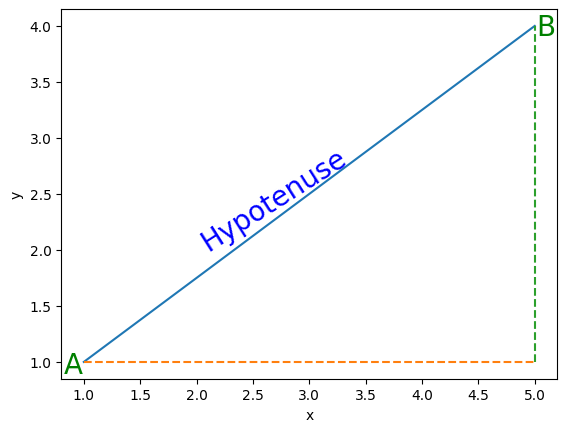

In [ ]:
# Point A is [1,1]
# Point B is [5,4]
#test kc euclid 2d

fig = plt.figure()
fig, ax = plt.subplots()
ax.plot([1,5], [1,4], linestyle = 'solid')
ax.text(0.82,0.9, "A", color='green', size=20)
ax.text(5.01,3.92, "B", color='green', size=20)
ax.text(2,2, "Hypotenuse", color='blue', rotation=32.5, size=20)

#add x, y sides of the triangle
ax.plot([1,5], [1,1], linestyle='dashed')
ax.plot([5,5], [1,4], linestyle='dashed')

ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

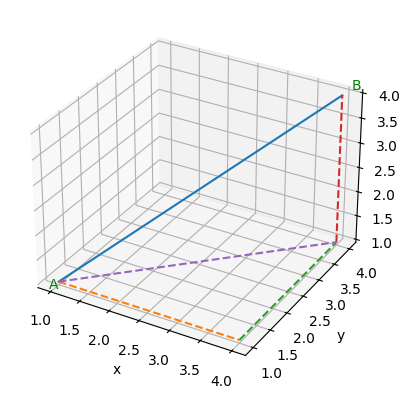

In [ ]:
#3d
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update(plt.rcParamsDefault)
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
# Point A is [1,1,1]
# Point B is [4,4,4]
ax.plot([1,4], [1,4], [1,4], linestyle='solid')
ax.text(0.9,0.9,0.9, "A", color='green')
ax.text(4.1,4.1,4.1, "B", color='green')
# Add the x, y and z sides of the triangular pyramid
ax.plot([1,4], [1,1], [1,1], linestyle='dashed')
ax.plot([4,4], [1,4], [1,1], linestyle='dashed')
ax.plot([4,4], [4,4], [1,4], linestyle='dashed')
ax.plot([1,4], [1,4], [1,1], linestyle='dashed')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [ ]:
#kc Euclidean
print("The Euclidean distance from A to B is equal to")
print(np.sqrt( 3**2 + 3**2 + 3**2 ))

The Euclidean distance from A to B is equal to
5.196152422706632


In [ ]:
# dinh nghia euclid 2 diem 
def euclid_distance(p1, p2):

    # tao 1 so de luu
    sum_of_square_distances = 0
    for a,b in zip(p1,p2):
        distance = (a - b)**2
        sum_of_square_distances = sum_of_square_distances + distance

    euclidean_distance = np.sqrt(sum_of_square_distances)
    return euclidean_distance

point1 = (5,6,7,8,9,10)
point2 = (1,2,3,4,5,6)

print(euclid_distance(point1, point2))


9.797958971132712


Xác định nhãn của các điểm "k" trong tập dữ liệu của chúng tôi với khoảng cách nhỏ nhất

In [ ]:
def labels_of_nearest_neighbours(np_list_of_distances, np_list_of_labels, k):
    """
    np_list_of_distances: Đây là một mảng numpy chứa khoảng cách giữa điểm mới (chưa có nhãn) và các điểm đã biết trong tập huấn luyện.

    np_list_of_labels: Đây là một mảng numpy chứa nhãn của các điểm đã biết trong tập huấn luyện.

    k: Đây là số lượng điểm lân cận gần nhất (số lượng "neighbors") mà bạn muốn xem xét để đưa ra dự đoán cho điểm mới.
    """
    #dinh hinh lai ca hai danh sach 
    np_list_of_distances = np_list_of_distances.reshape(-1, 1)
    np_list_of_labels = np_list_of_labels.reshape(-1, 1)

    #noi thang mang
    np_distances_and_labels = np.concatenate((np_list_of_distances, np_list_of_labels), axis=1)
    labels_df = pd.DataFrame(np_distances_and_labels, columns=['distance','label'])

    # sắp xếp các mục trong khung dữ liệu theo khoảng cách
    labels_df = labels_df.sort_values('distance')
    return labels_df['label'].head(k).values

Xác định các nhãn phổ biến nhất

In [ ]:
from collections import Counter
def most_common_label(np_arr_of_labels):
    """
    np_list_of_labels: một mảng nhãn numpy
    """
    mostCommon = Counter(np_arr_of_labels).most_common(1)
    return mostCommon[0][0]


KNN

In [ ]:
def simple_KNN( new_point, existing_points, labels_for_existing_points, k=2):
    """
    new_point: Một Series của pandas tương ứng với điểm mới có nhãn chưa biết.
    existing_points: Một DataFrame của pandas chứa các điểm đã biết.
    labels_for_existing_points: Một Series của pandas chứa các nhãn tương ứng với các điểm đã biết.
    k: Số lượng hàng xóm gần nhất cần xem xét khi xác định nhãn cho điểm mới.
    Nếu không chỉ định k, giá trị mặc định sẽ là 2.

    Trả về: Nhãn được dự đoán cho điểm mới.
    """
    row_count_of_existing_points = existing_points.shape[0]
    # 1 khoảng trống
    list_of_distances = []

    # Tính khoảng cách euclid, thêm vào mảng
    for i in range(row_count_of_existing_points):
        this_distance = euclid_distance(new_point, existing_points.iloc[i])
        list_of_distances.append(this_distance)

    # Sử dụng list_of_distances và danh sách nhãn, xác định nhãn của các điểm có khoảng cách nhỏ nhất đến điểm mới
    labels_of_k_nearest_neighbours = labels_of_nearest_neighbours(np.array(list_of_distances), np.array(labels_for_existing_points), k)


    # Xác định nhãn phổ biến nhất
    predicted_label_of_new_point = most_common_label(labels_of_k_nearest_neighbours)
    return predicted_label_of_new_point

new_point = pd.Series([2,3])
k = 2


# test tren dummy data

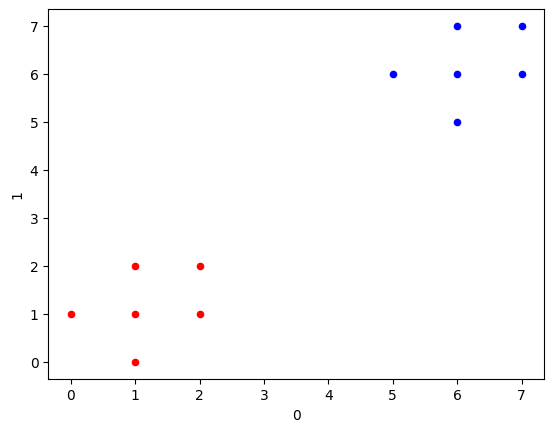

In [ ]:
# Create data
data1 = np.array([[0, 1],[1, 0],[1, 1],[1, 2],[2, 2], [2, 1]])
data2 = data1 + 5
dataframe1 = pd.DataFrame(data1)
dataframe2 = pd.DataFrame(data2)

# Create a scatterplot with the dataframe1 points in red, and the dataframe2 points in blue
ax1 = dataframe1.plot.scatter(0,1, color='red')
dataframe2.plot.scatter(0,1, color='blue', ax=ax1)
plt.show()

# Đánh giả thử

In [ ]:
# y_pred = []
# k = 3  # bạn có thể thay đổi k tùy ý

# # Dự đoán từng điểm trong X_val
# for i in range(len(X_val)):
#     new_point = X_val.iloc[i]
#     pred = simple_KNN(new_point, X_train, y_train, k)
#     y_pred.append(pred)

# # Tính độ chính xác
# acc = accuracy_score(y_val, y_pred)
# print("Accuracy của simple_KNN:", acc)

Using the simple KNN on the test set of the hand written digits

In [ ]:
df_test_data.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


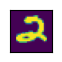

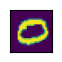

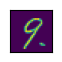

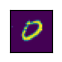

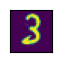

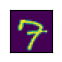

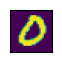

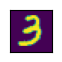

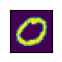

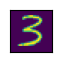

In [ ]:
# hien thi anh dau tien
for i in range(10):
    ax= plt.subplot(1,10 ,i+1)
    im=ax.imshow(df_test_data.iloc[i].values.reshape(28,28))
    plt.xlabel=''
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.show()


In [ ]:
# set newpoint
new_point = df_test_data.iloc[0]
print(new_point)

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Name: 0, Length: 784, dtype: int64


In [ ]:
# kiểm tra bằng cách so sánh hình ảnh thử nghiệm với 1000 mục đầu tiên
print(simple_KNN(new_point, X_train.head(1000), y_train.head(1000), k))

2.0


In [ ]:
from scipy import spatial

tree = spatial.cKDTree(X_train.head(1000))
mindist, minid = tree.query(df_test_data.head(1))            # nên có shape (1, 784)
print(mindist, minid)
# we can use the minid to reference the label of the nearest point to our test point (the first digit in our test data is the number 2)
print(y_train[minid])

[1385.39813772] [982]
982    2
Name: label, dtype: int64


In [ ]:
from scipy import spatial

def faster_KNN(X_test, X_train, y_labels, output_file=None):
    predictions_list = []
    tree = spatial.cKDTree(X_train.to_numpy())
    number_of_test_data_points = len(X_test)

    for point in range(number_of_test_data_points):
        mindist, minid = tree.query(X_test.iloc[point])
        this_prediction = y_labels.iloc[minid]
        predictions_list.append(this_prediction)

        # Nếu cần ghi file
        if output_file is not None:
            output_file.write(f"{point+1},{this_prediction}\n")
    
    return predictions_list  # ✅ Trả về kết quả để tính accuracy


In [ ]:
# Sau đó đánh giá
acc = accuracy_score(y_val, y_pred)
print("Accuracy của faster_KNN:", acc)

In [ ]:
# Ghi kết quả ra file
output_file = open("predictions.csv", "w")
output_file.write("ImageId,Label\n")
faster_KNN(df_test_data,X_train.head(2000), y_train.head(2000), output_file)
# GỌI HÀM KÈM output_file
output_file.close()